
This script combines multiple recommendation approaches:
1. Baseline Collaborative Filtering
2. Knowledge Graph (with genre-based recommendation)
3. Graph Retrieval (with embedding-based recommendation)
4. LLM-integrated Graph Recommendation (both with local model and API options)

All methods are evaluated on the same MovieLens 100K dataset with consistent metrics.

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### imports

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import math
import random
import os
import json
import torch
from typing import Dict, List, Set, Tuple, Optional, Union, Any
import requests
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Data Loading Functions

In [3]:
def load_movielens_data(ratings_url, movies_url, test_file=None, train_file=None):
    """
    Load MovieLens data from files or create train/test split if not provided.

    Args:
        ratings_url: Path to ratings file
        movies_url: Path to movies/items file
        test_file: Optional path to test data file
        train_file: Optional path to train data file

    Returns:
        train_df, test_df: Pandas DataFrames with train and test data
        movies_df: DataFrame with movie information
    """
    # Load full ratings data
    ratings = pd.read_csv(ratings_url, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

    # Load movie data
    movies_df = pd.read_csv(movies_url, sep='|', encoding='latin-1', header=None)
    genre_list = ["Unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                 "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
                 "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
    movies_df.columns = ['movie_id', 'title', 'release_date', 'video_release', 'IMDb_url'] + genre_list

    # If train/test files are provided, use them
    if train_file and test_file and os.path.exists(train_file) and os.path.exists(test_file):
        train_df = pd.read_csv(train_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        test_df = pd.read_csv(test_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    else:
        # Otherwise, create an 80/20 split per user
        train_list = []
        test_list = []
        user_groups = ratings.groupby('user_id')
        for user, group in user_groups:
            n_ratings = len(group)
            n_test = max(1, int(0.2 * n_ratings))
            test_idx = set(random.sample(list(group.index), n_test))
            for idx, row in group.iterrows():
                if idx in test_idx:
                    test_list.append(row)
                else:
                    train_list.append(row)

        train_df = pd.DataFrame(train_list).reset_index(drop=True)
        test_df = pd.DataFrame(test_list).reset_index(drop=True)

    print(f"Total ratings: {len(ratings)}")
    print(f"Training set size: {len(train_df)}, Testing set size: {len(test_df)}")

    return train_df, test_df, movies_df

def load_movielens_dict_format(train_file, test_file, item_file):
    """
    Load MovieLens data in dictionary format (for the LLM+Graph approach).
    """
    # Load movie genre information
    genre_names = []
    movie_genres = {}

    # Read genre names
    genre_file = item_file.replace('u.item', 'u.genre')
    with open(genre_file, 'r') as fg:
        genre_names = [line.split('|')[0] for line in fg if line.strip()]

    # Read movie info
    with open(item_file, 'r', encoding='latin-1') as f:
        for line in f:
            parts = line.strip().split('|')
            if len(parts) < 6:
                continue
            movie_id = int(parts[0])
            genre_flags = list(map(int, parts[5:5+19]))
            # Map genre flags to genre names
            genres = [genre_names[i] for i, flag in enumerate(genre_flags) if flag == 1]
            movie_genres[movie_id] = genres

    # Load train and test ratings into dictionaries
    def load_ratings(file_path):
        ratings = {}
        with open(file_path, 'r') as f:
            for line in f:
                user, item, rating, _ = line.split()
                user, item, rating = int(user), int(item), float(rating)
                ratings.setdefault(user, {})[item] = rating
        return ratings

    train_ratings = load_ratings(train_file)
    test_ratings = load_ratings(test_file)

    # Load movie titles
    movie_titles = {}
    with open(item_file, 'r', encoding='latin-1') as f:
        for line in f:
            parts = line.strip().split('|')
            if len(parts) >= 2:
                movie_id = int(parts[0])
                title = parts[1]
                movie_titles[movie_id] = title

    return train_ratings, test_ratings, movie_genres, movie_titles


# Collaborative Filtering

In [4]:
def build_collaborative_filtering_model(train_df):
    """
    Build a user-based collaborative filtering model using Pearson correlation.

    Returns:
        user_mean: Dictionary of user mean ratings
        user_ratings: Dictionary of user ratings normalized by user mean
        neighbors: Dictionary of top-N neighbors for each user
    """
    # Compute user mean ratings in training set for normalization
    user_mean = train_df.groupby('user_id')['rating'].mean().to_dict()

    # Build a dictionary of user -> {item: rating_diff} (rating_diff = rating - user_mean)
    user_ratings = defaultdict(dict)
    for _, row in train_df.iterrows():
        u, i, r = int(row['user_id']), int(row['item_id']), row['rating']
        user_ratings[u][i] = r - user_mean[u]

    # Precompute norm for each user's rating vector (for Pearson correlation)
    user_norm = {}
    for u, items in user_ratings.items():
        norm = math.sqrt(sum((diff)**2 for diff in items.values()))
        user_norm[u] = norm

    # Function to compute Pearson similarity between two users
    def user_similarity(u, v):
        if u not in user_ratings or v not in user_ratings:
            return 0.0
        # Find common items both u and v rated
        common_items = set(user_ratings[u].keys()) & set(user_ratings[v].keys())
        if len(common_items) == 0:
            return 0.0
        # Sum of product of normalized ratings for common items
        num = sum(user_ratings[u][i] * user_ratings[v][i] for i in common_items)
        den = user_norm[u] * user_norm[v]
        return num/den if den != 0 else 0.0

    # Compute top-N neighbors for each user
    N = 20  # number of neighbors to use
    neighbors = {}
    for u in user_ratings:
        # Compute similarity of u with every other user
        sims = []
        for v in user_ratings:
            if u == v:
                continue
            sim_uv = user_similarity(u, v)
            if sim_uv > 0:  # only consider positive similarities
                sims.append((sim_uv, v))
        # Sort by similarity and take top N
        sims.sort(reverse=True, key=lambda x: x[0])
        neighbors[u] = sims[:N]

    return user_mean, user_ratings, neighbors

def recommend_cf(user, user_mean, user_ratings, neighbors, train_df, K=5):
    """
    Generate top-K recommendations for a user using user-based CF.

    Args:
        user: User ID
        user_mean, user_ratings, neighbors: Model components from build_collaborative_filtering_model
        train_df: Training data
        K: Number of recommendations

    Returns:
        List of top-K recommended item IDs
    """
    # Items the user already rated in train
    seen_items = set(train_df[train_df['user_id'] == user]['item_id'])

    # Predict scores for unseen items
    scores = {}
    for sim, v in neighbors.get(user, []):
        for item, rating_diff in user_ratings[v].items():
            if item in seen_items:
                continue
            # Accumulate weighted sum of (neighbor's rating diff) * sim
            if item not in scores:
                scores[item] = {'num': 0.0, 'den': 0.0}
            scores[item]['num'] += sim * rating_diff
            scores[item]['den'] += abs(sim)

    # Compute final predicted rating = user_mean + weighted sum / sum of weights
    preds = []
    for item, agg in scores.items():
        if agg['den'] == 0:
            pred_rating = user_mean.get(user, 0)  # if no neighbor info, use user mean
        else:
            pred_rating = user_mean.get(user, 0) + agg['num'] / agg['den']
        preds.append((pred_rating, item))

    # Sort predictions by predicted rating descending
    preds.sort(reverse=True, key=lambda x: x[0])

    # Return top K item IDs
    return [item for _, item in preds[:K]]


# Knowledge Graph (Genre-Based) Recommendation

In [5]:
def build_kg_model(train_df, movies_df, genre_list):
    """
    Build a knowledge graph model based on movie genres.

    Returns:
        movie_genres: Dictionary of movie ID to set of genres
        movie_popularity: Dictionary of movie popularity (rating count)
    """
    # Build dictionary: movie_id -> set of genres
    movie_genres = {}
    for _, row in movies_df.iterrows():
        mid = int(row['movie_id'])
        # Collect all genres where value is 1
        genres = {genre for genre in genre_list if row[genre] == 1}
        movie_genres[mid] = genres

    # Compute popularity (rating count) for tie-breaking
    movie_train_ratings = train_df.groupby('item_id')['rating'].agg(['count','mean']).reset_index()
    movie_popularity = movie_train_ratings.set_index('item_id')['count'].to_dict()

    return movie_genres, movie_popularity

def recommend_kg(user, train_df, movie_genres, movie_popularity, K=5):
    """
    Generate top-K recommendations for a user using KG (genre-based).

    Args:
        user: User ID
        train_df: Training data
        movie_genres: Dictionary of movie ID to set of genres
        movie_popularity: Dictionary of movie popularity
        K: Number of recommendations

    Returns:
        List of top-K recommended item IDs
    """
    # Identify genres liked by the user (from training data, rating >=4)
    liked_genres = set()
    user_train_ratings = train_df[train_df['user_id'] == user]
    for _, row in user_train_ratings.iterrows():
        if row['rating'] >= 4:
            mid = int(row['item_id'])
            liked_genres |= movie_genres.get(mid, set())

    # If no liked genres, recommend popular movies
    if not liked_genres:
        popular_items = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)
        return [item for item, _ in popular_items if item not in user_train_ratings['item_id'].values][:K]

    # Gather candidate movies matching genres that user hasn't seen
    seen = set(user_train_ratings['item_id'])
    candidates = []
    for mid, genres in movie_genres.items():
        if mid in seen:
            continue
        overlap = len(genres & liked_genres)
        if overlap > 0:
            # Use overlap count and popularity as scores
            pop = movie_popularity.get(mid, 0)
            candidates.append((overlap, pop, mid))

    # Sort by overlap (primary) and popularity (secondary)
    candidates.sort(reverse=True, key=lambda x: (x[0], x[1]))

    # Return top K movie IDs
    return [mid for _, _, mid in candidates[:K]]

# Graph-Based Retrieval

In [6]:

def build_metadata_graph(movie_genres):
    """
    Build a bipartite graph connecting movies to their genres.

    Returns:
        G: NetworkX graph with movie and genre nodes
    """
    G = nx.Graph()
    for movie_id, genres in movie_genres.items():
        movie_node = f"movie_{movie_id}"
        G.add_node(movie_node, type='movie', movie_id=movie_id)
        for genre in genres:
            genre_node = f"genre_{genre}"
            G.add_node(genre_node, type='genre', name=genre)
            # Connect movie to each of its genres
            G.add_edge(movie_node, genre_node)
    return G

def build_user_profiles(train_df, movie_genres):
    """
    Build taste profiles for each user based on their highly-rated movies.

    Returns:
        Dictionary of user ID to genre preference counts
    """
    user_profiles = {}
    for user_id in train_df['user_id'].unique():
        user_data = train_df[train_df['user_id'] == user_id]

        # Consider movies rated 4 or higher as "liked"
        liked_movies = user_data[user_data['rating'] >= 4]['item_id'].tolist()

        # Count genre frequencies from liked movies
        genre_counts = {}
        for movie_id in liked_movies:
            for genre in movie_genres.get(movie_id, set()):
                genre_counts[genre] = genre_counts.get(genre, 0) + 1

        user_profiles[user_id] = genre_counts

    return user_profiles

def get_candidate_movies(user_profile, G):
    """
    Retrieve candidate movies from the graph based on user's genre preferences.

    Returns:
        Set of candidate movie IDs
    """
    candidates = set()
    for genre, weight in user_profile.items():
        genre_node = f"genre_{genre}"
        if G.has_node(genre_node):
            # Add all movies connected to this genre node
            for neighbor in G.neighbors(genre_node):
                if G.nodes[neighbor].get('type') == 'movie':
                    candidates.add(G.nodes[neighbor]['movie_id'])
    return candidates

def rank_candidates_for_user(user_id, candidates, user_profile, movie_genres, train_df):
    """
    Score and rank candidate movies for a user.

    Returns:
        List of ranked movie IDs
    """
    # Precompute popularity (rating count in training)
    popularity = train_df.groupby('item_id')['rating'].count().to_dict()

    # Get items the user has already seen
    user_train = train_df[train_df['user_id'] == user_id]
    seen_items = set(user_train['item_id'])

    scored = []
    for movie in candidates:
        if movie in seen_items:
            continue  # skip movies user already rated

        # Score based on genre overlap
        score = 0
        for genre in movie_genres.get(movie, set()):
            if genre in user_profile:
                score += user_profile[genre]  # add weight for each preferred genre

        # Add small popularity factor
        score += 0.001 * popularity.get(movie, 0)
        scored.append((movie, score))

    # Sort by score descending
    scored.sort(key=lambda x: x[1], reverse=True)
    return [movie for movie, _ in scored]

def recommend_graph_retrieval(user_id, user_profiles, G, movie_genres, train_df, K=5):
    """
    Generate top-K recommendations using graph-based retrieval.

    Args:
        user_id: User ID
        user_profiles: Dictionary of user genre preferences
        G: Graph connecting movies and genres
        movie_genres: Dictionary of movie genres
        train_df: Training data
        K: Number of recommendations

    Returns:
        List of top-K recommended item IDs
    """
    user_profile = user_profiles.get(user_id, {})
    if not user_profile:
        # Fallback for users with no profile: recommend popular movies
        popularity = train_df.groupby('item_id')['rating'].count().to_dict()
        seen_items = set(train_df[train_df['user_id'] == user_id]['item_id'])
        ranked = sorted([(item, count) for item, count in popularity.items() if item not in seen_items],
                         key=lambda x: x[1], reverse=True)
        return [item for item, _ in ranked[:K]]

    # Get candidate movies from the graph
    candidates = get_candidate_movies(user_profile, G)

    # Rank candidates
    ranked = rank_candidates_for_user(user_id, candidates, user_profile, movie_genres, train_df)

    # Return top K
    return ranked[:K]

# LLM Integration

In [7]:
class LLMIntegration:
    """Base class for LLM integration with recommendation systems."""

    def __init__(self, use_api=False, api_key=None, model_name=None):
        """
        Initialize LLM integration.

        Args:
            use_api: Whether to use external API (True) or local model (False)
            api_key: API key for external LLM service (if use_api=True)
            model_name: Name of model to load locally (if use_api=False)
        """
        self.use_api = use_api
        self.api_key = api_key
        self.model_name = model_name
        self.model = None
        self.tokenizer = None

        # Initialize the model if not using API
        if not use_api and model_name:
            self._init_local_model()

    def _init_local_model(self):
        """Initialize a local LLM model."""
        print(f"Loading local model: {self.model_name}")
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                device_map="auto"
            )
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def generate_text(self, prompt, max_length=100):
        """Generate text using either API or local model."""
        if self.use_api:
            return self._generate_with_api(prompt, max_length)
        else:
            return self._generate_with_local_model(prompt, max_length)

    def _generate_with_api(self, prompt, max_length):
        """Generate text using external API."""
        try:
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {self.api_key}"
            }

            payload = {
                "model": "gpt-3.5-turbo",  # Adjust model as needed
                "messages": [{"role": "user", "content": prompt}],
                "max_tokens": max_length
            }

            response = requests.post(
                "https://api.openai.com/v1/chat/completions",
                headers=headers,
                json=payload
            )

            if response.status_code == 200:
                return response.json()["choices"][0]["message"]["content"]
            else:
                print(f"API error: {response.status_code}")
                print(response.text)
                return ""

        except Exception as e:
            print(f"Error in API call: {e}")
            return ""

    def _generate_with_local_model(self, prompt, max_length):
        """Generate text using local model."""
        try:
            if not self.model or not self.tokenizer:
                raise ValueError("Model not initialized")

            # Truncate prompt if needed
            if len(prompt) > 500:
                prompt_parts = prompt.split('\n')
                if len(prompt_parts) > 6:
                    prompt = '\n'.join(prompt_parts[:3] + ["..."] + prompt_parts[-3:])

            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=800).to(self.model.device)

            try:
                with torch.no_grad():
                    outputs = self.model.generate(
                        **inputs,
                        max_length=min(1000, max_length + inputs["input_ids"].shape[1]),
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                    )

                response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                if response.startswith(prompt):
                    response = response[len(prompt):]
                return response.strip()

            except IndexError:
                # Fallback for some models
                print("Using alternative generation approach")
                with torch.no_grad():
                    input_ids = inputs["input_ids"]
                    generated = input_ids
                    for _ in range(min(50, max_length)):
                        outputs = self.model(input_ids=generated)
                        next_token_logits = outputs.logits[:, -1, :]
                        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                        generated = torch.cat([generated, next_token], dim=1)
                        if next_token.item() == self.tokenizer.eos_token_id:
                            break

                response = self.tokenizer.decode(generated[0], skip_special_tokens=True)
                if response.startswith(prompt):
                    response = response[len(prompt):]
                return response.strip()

        except Exception as e:
            print(f"Error generating text: {e}")
            return ""

    def analyze_user_preferences(self, user_ratings, movie_genres, movie_titles):
        """
        Use LLM to analyze user preferences based on ratings.

        Returns:
            Dictionary of genre preferences with scores
        """
        # Statistical analysis as fallback
        genre_counts = {}
        genre_ratings = defaultdict(list)

        for movie_id, rating in user_ratings.items():
            if rating >= 4:  # Consider highly rated movies
                for genre in movie_genres.get(int(movie_id), set()):
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
                    genre_ratings[genre].append(rating)

        # Calculate genre scores
        genre_scores = {}
        for genre, count in genre_counts.items():
            avg_rating = sum(genre_ratings[genre]) / len(genre_ratings[genre])
            norm_rating = (avg_rating - 1) / 4  # Normalize to 0-1
            score = count * (0.5 + 0.5 * norm_rating)
            genre_scores[genre] = score

        # Normalize scores
        if genre_scores:
            max_score = max(genre_scores.values())
            genre_scores = {genre: score/max_score for genre, score in genre_scores.items()}

        # Skip LLM for simple models
        if not self.use_api and self.model_name in ["gpt2", "distilgpt2"]:
            return genre_scores

        # Use LLM for enhanced analysis
        try:
            # Create simplified prompt with limited data
            top_movies = []
            movie_count = 0
            for movie_id, rating in sorted(user_ratings.items(), key=lambda x: x[1], reverse=True):
                if rating >= 4 and movie_count < 5:
                    title = movie_titles.get(int(movie_id), f"Movie {movie_id}")
                    genres = list(movie_genres.get(int(movie_id), set()))
                    top_movies.append({"title": title, "genres": genres, "rating": rating})
                    movie_count += 1

            # Create prompt
            prompt = f"Based on these favorite movies, which genres does this user prefer most? Movies: {str(top_movies)[:300]}... Just list top 3-5 genres in order."

            # Get LLM response
            response = self.generate_text(prompt, max_length=100)

            if response:
                # Parse response for genres
                all_genres = set()
                for _, genres in movie_genres.items():
                    all_genres.update(genres)

                # Search for genres in response
                found_genres = {}
                for genre in all_genres:
                    if genre.lower() in response.lower():
                        position = response.lower().find(genre.lower())
                        found_genres[genre] = 1.0 - (position / len(response)) * 0.5

                # Blend with statistical scores
                if found_genres:
                    max_new_score = max(found_genres.values()) if found_genres else 1
                    found_genres = {g: s/max_new_score for g, s in found_genres.items()}

                    # 70% statistical, 30% LLM
                    for genre in set(list(genre_scores.keys()) + list(found_genres.keys())):
                        stat_score = genre_scores.get(genre, 0.0)
                        llm_score = found_genres.get(genre, 0.0)
                        genre_scores[genre] = 0.7 * stat_score + 0.3 * llm_score

            return genre_scores

        except Exception as e:
            print(f"Error in LLM preference analysis: {e}")
            return genre_scores

In [8]:
class LLMGraphRecommender:
    """Movie recommender using LLM + Knowledge Graph."""

    def __init__(self, train_ratings, movie_genres, movie_titles, use_llm_api=False, api_key=None, model_name=None):
        """
        Initialize the LLM + Graph recommender.

        Args:
            train_ratings: Dictionary of training ratings {user_id: {item_id: rating}}
            movie_genres: Dictionary of movie genres {movie_id: set(genres)}
            movie_titles: Dictionary of movie titles {movie_id: title}
            use_llm_api: Whether to use external API
            api_key: API key if using API
            model_name: Model name if using local model
        """
        self.train_ratings = train_ratings
        self.movie_genres = {int(k): v for k, v in movie_genres.items()}  # Ensure int keys
        self.movie_titles = movie_titles

        # Use LLM if possible
        self.use_llm = (use_llm_api and api_key) or (not use_llm_api and model_name)

        if self.use_llm:
            print(f"Initializing LLM integration: API={use_llm_api}, Model={model_name if model_name else 'N/A'}")
            self.llm = LLMIntegration(
                use_api=use_llm_api,
                api_key=api_key,
                model_name=model_name
            )
        else:
            print("LLM integration disabled, using statistical methods only")
            self.llm = None

        # Build the knowledge graph
        self.graph = self._build_knowledge_graph()

        # Precompute popularity
        self.popularity = self._compute_movie_popularity()

    def _build_knowledge_graph(self):
        """Build movie-genre knowledge graph."""
        G = nx.Graph()

        # Add movie and genre nodes
        for movie_id, genres in self.movie_genres.items():
            movie_node = f"movie_{movie_id}"
            G.add_node(movie_node, type='movie', movie_id=movie_id)

            for genre in genres:
                genre_node = f"genre_{genre}"
                G.add_node(genre_node, type='genre', name=genre)
                # Connect movie to genre
                G.add_edge(movie_node, genre_node)

        return G

    def _compute_movie_popularity(self):
        """Compute movie popularity as rating count."""
        popularity = {}
        for user_ratings in self.train_ratings.values():
            for movie_id in user_ratings:
                popularity[int(movie_id)] = popularity.get(int(movie_id), 0) + 1
        return popularity

    def _build_user_profile(self, user_id, use_llm=True):
        """Build user profile using either LLM or traditional method."""
        if user_id not in self.train_ratings:
            return {}

        if use_llm and self.use_llm:
            return self.llm.analyze_user_preferences(
                self.train_ratings[user_id],
                self.movie_genres,
                self.movie_titles
            )
        else:
            # Traditional method (genre counts)
            user_ratings = self.train_ratings[user_id]
            genre_counts = {}

            # Count genres in highly rated movies
            for movie_id, rating in user_ratings.items():
                if rating >= 4:
                    for genre in self.movie_genres.get(int(movie_id), set()):
                        genre_counts[genre] = genre_counts.get(genre, 0) + 1

            return genre_counts

    def _get_candidate_movies(self, user_profile):
        """Get candidate movies from knowledge graph based on user profile."""
        candidates = set()

        for genre, weight in user_profile.items():
            genre_node = f"genre_{genre}"
            if self.graph.has_node(genre_node):
                # Add all movies connected to this genre node
                for neighbor in self.graph.neighbors(genre_node):
                    if self.graph.nodes[neighbor].get('type') == 'movie':
                        candidates.add(self.graph.nodes[neighbor]['movie_id'])

        return candidates

    def _rank_candidates(self, user_id, candidates, user_profile):
        """Rank candidate movies based on user profile."""
        if not candidates or not user_profile:
            # Fallback to popularity-based recommendation
            return sorted(
                [m for m in self.popularity.keys() if m not in self.train_ratings.get(user_id, {})],
                key=lambda x: self.popularity.get(x, 0),
                reverse=True
            )

        # Score candidates based on genre match and popularity
        scored = []
        for movie_id in candidates:
            if str(movie_id) in self.train_ratings.get(user_id, {}) or movie_id in self.train_ratings.get(user_id, {}):
                continue  # Skip already rated movies

            # Calculate genre match score
            score = 0
            for genre in self.movie_genres.get(movie_id, set()):
                if genre in user_profile:
                    score += user_profile[genre]

            # Add popularity factor for tie-breaking
            popularity_boost = 0.001 * self.popularity.get(movie_id, 0)
            score += popularity_boost

            scored.append((movie_id, score))

        # Sort by score
        scored.sort(key=lambda x: x[1], reverse=True)
        return [movie_id for movie_id, _ in scored]

    def _generate_explanation(self, user_id, recommendations, user_profile):
        """Generate recommendation explanation using LLM."""
        # Simple explanation for small models
        if not self.llm or (not self.llm.use_api and self.llm.model_name in ["gpt2", "distilgpt2"]):
            # Get top genres from user profile
            top_genres = sorted(user_profile.items(), key=lambda x: x[1], reverse=True)[:3]
            top_genre_names = [genre for genre, _ in top_genres]

            # Get genres from recommended movies
            recommended_genres = set()
            for movie_id in recommendations[:3]:
                recommended_genres.update(self.movie_genres.get(movie_id, set()))

            # Create simple explanation
            explanation = f"These movies were recommended because you seem to enjoy {', '.join(top_genre_names)} films. "
            explanation += f"The recommended movies include genres like {', '.join(list(recommended_genres)[:5])}."

            return explanation

        # More sophisticated explanation with API or larger models
        try:
            # Get info about recommended movies
            movie_data = []
            for movie_id in recommendations[:3]:  # Just top 3 for brevity
                title = self.movie_titles.get(movie_id, f"Movie {movie_id}")
                genres = list(self.movie_genres.get(movie_id, set()))
                movie_data.append({
                    "title": title,
                    "genres": genres
                })

            # Get top user preferences
            preferences = sorted(user_profile.items(), key=lambda x: x[1], reverse=True)
            top_genres = [genre for genre, _ in preferences[:3]]  # Top 3 genres

            # Create prompt
            prompt = f"Explain why these movies match a user who likes {', '.join(top_genres)}. Movies: {str(movie_data)[:200]}... Keep it under 50 words."

            # Generate explanation
            explanation = self.llm.generate_text(prompt, max_length=100)

            if not explanation or len(explanation) < 20:
                # Fallback
                explanation = f"These movies were recommended because you enjoy {', '.join(top_genres)} films."

            return explanation

        except Exception as e:
            print(f"Error generating explanation: {e}")
            # Fallback
            return f"These movies were recommended based on your preference for {', '.join(top_genres[:3])} films."

    def recommend(self, user_id, k=10, use_llm_profile=True, explain=False):
        """
        Generate recommendations for a user.

        Args:
            user_id: User ID
            k: Number of recommendations
            use_llm_profile: Whether to use LLM for user profiling
            explain: Whether to generate explanations

        Returns:
            Dictionary with recommendations and optional explanation
        """
        # Build user profile
        user_profile = self._build_user_profile(user_id, use_llm=use_llm_profile)

        # Get candidates
        candidates = self._get_candidate_movies(user_profile)

        # Rank candidates
        ranked_movies = self._rank_candidates(user_id, candidates, user_profile)

        # Get top-k recommendations
        recommendations = ranked_movies[:k]

        result = {"recommendations": recommendations}

        # Generate explanation if requested
        if explain and recommendations and self.use_llm:
            explanation = self._generate_explanation(user_id, recommendations, user_profile)
            result["explanation"] = explanation

        return result

def recommend_llm_kg(user_id, llm_recommender, k=5, explain=False):
    """
    Generate recommendations using LLM + Knowledge Graph approach.

    Args:
        user_id: User ID
        llm_recommender: LLM recommender instance
        k: Number of recommendations
        explain: Whether to provide explanation

    Returns:
        List of recommended movie IDs
    """
    result = llm_recommender.recommend(
        user_id=user_id,
        k=k,
        use_llm_profile=True,
        explain=explain
    )

    if explain and "explanation" in result:
        print(f"Explanation: {result['explanation']}")

    return result["recommendations"]


In [9]:
#############################################################
# Evaluation Functions
#############################################################

def precision_at_k(recommended_items, relevant_items, k):
    """Calculate Precision@K."""
    if k == 0:
        return 0.0
    recommended_items = recommended_items[:k]
    # Count how many recommended items are relevant
    hits = sum(1 for item in recommended_items if item in relevant_items)
    return hits / k

def recall_at_k(recommended_items, relevant_items, k):
    """Calculate Recall@K."""
    if len(relevant_items) == 0:
        return None  # No relevant items to recall
    recommended_items = recommended_items[:k]
    hits = sum(1 for item in recommended_items if item in relevant_items)
    return hits / len(relevant_items)

def ndcg_at_k(recommended_items, relevant_items, k):
    """Calculate NDCG@K."""
    recommended_items = recommended_items[:k]
    DCG = 0.0
    for rank, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            # relevance = 1 if relevant
            DCG += 1.0 / (math.log2(rank + 1))
    # Compute ideal DCG (IDCG)
    relevant_count = min(len(relevant_items), k)
    IDCG = 0.0
    for rank in range(1, relevant_count + 1):
        IDCG += 1.0 / (math.log2(rank + 1))
    return DCG / IDCG if IDCG > 0 else 0.0

def evaluate_recommendations(recommender_func, test_df, K, **kwargs):
    """
    Evaluate a recommender function.

    Args:
        recommender_func: Function that generates recommendations
        test_df: Test data
        K: Recommendation list length
        kwargs: Additional arguments for recommender_func

    Returns:
        Tuple of (precision, recall, ndcg)
    """
    # Prepare relevant items for each user (items in test with rating >= 4)
    test_relevant = defaultdict(set)
    for _, row in test_df.iterrows():
        u = int(row['user_id']); i = int(row['item_id']); r = row['rating']
        if r >= 4:
            test_relevant[u].add(i)

    total_precision = total_recall = total_ndcg = 0.0
    user_count = 0
    recall_count = 0

    # Sample users for faster evaluation (comment this out for full evaluation)
    # sample_size = min(100, len(test_relevant))
    # test_users = random.sample(list(test_relevant.keys()), sample_size)

    # Evaluate for all users
    test_users = list(test_relevant.keys())

    for user in test_users:
        rel_items = test_relevant.get(user, set())
        if not rel_items:
            continue  # Skip users with no relevant items

        # Generate recommendations for this user
        try:
            recs = recommender_func(user, K=K, **kwargs)
        except Exception as e:
            print(f"Error generating recommendations for user {user}: {e}")
            continue

        # Calculate metrics
        p = precision_at_k(recs, rel_items, K)
        ndcg = ndcg_at_k(recs, rel_items, K)
        r = recall_at_k(recs, rel_items, K)

        total_precision += p
        total_ndcg += ndcg
        if r is not None:
            total_recall += r
            recall_count += 1

        user_count += 1

    # Calculate averages
    avg_precision = total_precision / user_count if user_count > 0 else 0
    avg_recall = total_recall / recall_count if recall_count > 0 else 0
    avg_ndcg = total_ndcg / user_count if user_count > 0 else 0

    return avg_precision, avg_recall, avg_ndcg

def evaluate_llm_kg_recommendations(llm_recommender, test_ratings, k=10):
    """
    Evaluate LLM + KG recommendation approach.

    Args:
        llm_recommender: LLM recommender instance
        test_ratings: Test ratings dictionary
        k: Recommendation list length

    Returns:
        Dictionary of evaluation metrics
    """
    total_precision = total_recall = total_ndcg = 0.0
    user_count = 0

    for user_id in test_ratings.keys():
        # Get relevant items (with rating >= 4)
        relevant = {int(item) for item, rating in test_ratings[user_id].items() if rating >= 4}
        if not relevant:
            continue  # Skip users with no relevant items

        # Get recommendations
        recommendations = recommend_llm_kg(user_id, llm_recommender, k=k)

        # Calculate metrics
        hits = sum(1 for item in recommendations[:k] if item in relevant)

        # Precision@k and Recall@k
        precision = hits / k
        recall = hits / len(relevant)

        # NDCG@k
        dcg = sum(1.0 / math.log2(i+2) for i, item in enumerate(recommendations[:k]) if item in relevant)
        ideal_hits = min(len(relevant), k)
        idcg = sum(1.0 / math.log2(i+2) for i in range(ideal_hits))
        ndcg = dcg / idcg if idcg > 0 else 0.0

        total_precision += precision
        total_recall += recall
        total_ndcg += ndcg
        user_count += 1

    # Calculate average metrics
    if user_count > 0:
        avg_precision = total_precision / user_count
        avg_recall = total_recall / user_count
        avg_ndcg = total_ndcg / user_count
    else:
        avg_precision = avg_recall = avg_ndcg = 0.0

    return {
        'Precision@K': avg_precision,
        'Recall@K': avg_recall,
        'NDCG@K': avg_ndcg
    }


# RANDOM SAMPLES TESTING

In [10]:
def ab_test_recommendation_models(test_users, train_df, movie_titles, movie_genres, recommend_cf_wrapper,
                            recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5):
    """
    Perform A/B testing on multiple recommendation models.

    Args:
        test_users: List of user IDs to test on
        train_df: Training data DataFrame
        movie_titles: Dictionary of movie titles
        movie_genres: Dictionary of movie genres
        recommend_cf_wrapper: Function for CF recommendations
        recommend_kg_wrapper: Function for KG recommendations
        recommend_graph_wrapper: Function for Graph recommendations
        llm_recommender: LLM recommender instance
        K: Number of recommendations to generate

    Returns:
        DataFrame with comparison results
    """
    import pandas as pd

    # Results storage
    results = {
        'user_id': [],
        'cf_recs': [],
        'kg_recs': [],
        'graph_recs': [],
        'llm_kg_recs': [],
        'common_cf_kg': [],
        'common_cf_graph': [],
        'common_cf_llm': [],
        'common_kg_graph': [],
        'common_kg_llm': [],
        'common_graph_llm': []
    }

    print(f"Running A/B test on {len(test_users)} users with K={K}...")

    for user_id in test_users:
        print(f"\nTesting user {user_id}:")

        # Get recommendations from each model
        try:
            cf_recommendations = recommend_cf_wrapper(user_id, K=K)
            kg_recommendations = recommend_kg_wrapper(user_id, K=K)
            graph_recommendations = recommend_graph_wrapper(user_id, K=K)
            llm_kg_recommendations = recommend_llm_kg(user_id, llm_recommender, k=K)

            # Add to results
            results['user_id'].append(user_id)
            results['cf_recs'].append(cf_recommendations)
            results['kg_recs'].append(kg_recommendations)
            results['graph_recs'].append(graph_recommendations)
            results['llm_kg_recs'].append(llm_kg_recommendations)

            # Calculate overlap between models
            results['common_cf_kg'].append(len(set(cf_recommendations) & set(kg_recommendations)))
            results['common_cf_graph'].append(len(set(cf_recommendations) & set(graph_recommendations)))
            results['common_cf_llm'].append(len(set(cf_recommendations) & set(llm_kg_recommendations)))
            results['common_kg_graph'].append(len(set(kg_recommendations) & set(graph_recommendations)))
            results['common_kg_llm'].append(len(set(kg_recommendations) & set(llm_kg_recommendations)))
            results['common_graph_llm'].append(len(set(graph_recommendations) & set(llm_kg_recommendations)))

            # Print recommendations with movie titles for this user
            print(f"  CF: {[movie_titles.get(mid, f'Movie {mid}') for mid in cf_recommendations]}")
            print(f"  KG: {[movie_titles.get(mid, f'Movie {mid}') for mid in kg_recommendations]}")
            print(f"  Graph: {[movie_titles.get(mid, f'Movie {mid}') for mid in graph_recommendations]}")
            print(f"  LLM+KG: {[movie_titles.get(mid, f'Movie {mid}') for mid in llm_kg_recommendations]}")

        except Exception as e:
            print(f"Error for user {user_id}: {e}")

    # Create DataFrame from results
    results_df = pd.DataFrame(results)

    # Calculate agreement statistics
    print("\n=== Model Agreement Statistics ===")
    agreement_stats = {
        'Model Pair': ['CF-KG', 'CF-Graph', 'CF-LLM', 'KG-Graph', 'KG-LLM', 'Graph-LLM'],
        'Avg Overlap': [
            results_df['common_cf_kg'].mean(),
            results_df['common_cf_graph'].mean(),
            results_df['common_cf_llm'].mean(),
            results_df['common_kg_graph'].mean(),
            results_df['common_kg_llm'].mean(),
            results_df['common_graph_llm'].mean()
        ],
        'Overlap %': [
            100 * results_df['common_cf_kg'].mean() / K,
            100 * results_df['common_cf_graph'].mean() / K,
            100 * results_df['common_cf_llm'].mean() / K,
            100 * results_df['common_kg_graph'].mean() / K,
            100 * results_df['common_kg_llm'].mean() / K,
            100 * results_df['common_graph_llm'].mean() / K
        ]
    }

    agreement_df = pd.DataFrame(agreement_stats)
    print(agreement_df)

    return results_df


def test_with_highly_rated_movies(train_df, movie_genres, movie_titles, recommend_cf_wrapper,
                                recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender):
    """Test the recommendation quality with users who have highly rated specific movie genres."""
    # Convert movie_genres to the format expected by this function if needed
    if isinstance(next(iter(movie_genres.values())), list):
        # Convert from list to dict with 0/1 values
        movie_genres_dict = {}
        for mid, genres in movie_genres.items():
            movie_genres_dict[mid] = {genre: 1 for genre in genres}
    else:
        movie_genres_dict = movie_genres

    # Find users who rated action movies highly
    action_lovers = []
    for user_id in train_df['user_id'].unique():
        user_data = train_df[train_df['user_id'] == user_id]
        # Get movies this user rated 5
        high_rated = user_data[user_data['rating'] == 5]['item_id'].tolist()
        # Check if any of these are action movies
        action_movies = []
        for mid in high_rated:
            genres = movie_genres_dict.get(mid, {})
            if isinstance(genres, list):
                if 'Action' in genres:
                    action_movies.append(mid)
            else:
                if genres.get('Action', 0) == 1:
                    action_movies.append(mid)

        if len(action_movies) >= 2:  # User rated at least 2 action movies as 5
            action_lovers.append(user_id)
            if len(action_lovers) >= 5:  # Limit to 5 users
                break

    print(f"Found {len(action_lovers)} action movie lovers")

    # Find users who rated comedy movies highly
    comedy_lovers = []
    for user_id in train_df['user_id'].unique():
        if user_id in action_lovers:
            continue  # Skip users already in action_lovers
        user_data = train_df[train_df['user_id'] == user_id]
        high_rated = user_data[user_data['rating'] == 5]['item_id'].tolist()

        comedy_movies = []
        for mid in high_rated:
            genres = movie_genres_dict.get(mid, {})
            if isinstance(genres, list):
                if 'Comedy' in genres:
                    comedy_movies.append(mid)
            else:
                if genres.get('Comedy', 0) == 1:
                    comedy_movies.append(mid)

        if len(comedy_movies) >= 2:
            comedy_lovers.append(user_id)
            if len(comedy_lovers) >= 5:
                break

    print(f"Found {len(comedy_lovers)} comedy movie lovers")

    # Test action lovers
    print("\n=== Testing Action Movie Lovers ===")
    action_results = ab_test_recommendation_models(
        action_lovers, train_df, movie_titles, movie_genres,
        recommend_cf_wrapper, recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5
    )

    # Test comedy lovers
    print("\n=== Testing Comedy Movie Lovers ===")
    comedy_results = ab_test_recommendation_models(
        comedy_lovers, train_df, movie_titles, movie_genres,
        recommend_cf_wrapper, recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5
    )

    # Calculate genre distribution in recommendations
    print("\n=== Genre Distribution in Recommendations ===")

    def count_genres_in_recs(recommendations, movie_genres):
        genre_counts = {}
        for movie_id in recommendations:
            genres = movie_genres.get(movie_id, [])
            if isinstance(genres, list):
                for genre in genres:
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
            else:
                for genre, has_genre in genres.items():
                    if has_genre == 1:
                        genre_counts[genre] = genre_counts.get(genre, 0) + 1
        return genre_counts

    # Count genres for action lovers
    model_genre_counts = {
        'Model': ['CF', 'KG', 'Graph', 'LLM+KG'],
        'Action %': [],
        'Comedy %': [],
        'Drama %': [],
        'Thriller %': []
    }

    # Process each model's recommendations
    for model_name, recs_key in [
        ('CF', 'cf_recs'),
        ('KG', 'kg_recs'),
        ('Graph', 'graph_recs'),
        ('LLM+KG', 'llm_kg_recs')
    ]:
        # Flatten all recommendations for this model
        all_recs = [item for sublist in action_results[recs_key].tolist() for item in sublist]
        genre_counts = count_genres_in_recs(all_recs, movie_genres_dict)
        total = len(all_recs)

        # Calculate percentages
        action_pct = 100 * genre_counts.get('Action', 0) / total if total > 0 else 0
        comedy_pct = 100 * genre_counts.get('Comedy', 0) / total if total > 0 else 0
        drama_pct = 100 * genre_counts.get('Drama', 0) / total if total > 0 else 0
        thriller_pct = 100 * genre_counts.get('Thriller', 0) / total if total > 0 else 0

        model_genre_counts['Action %'].append(f"{action_pct:.1f}%")
        model_genre_counts['Comedy %'].append(f"{comedy_pct:.1f}%")
        model_genre_counts['Drama %'].append(f"{drama_pct:.1f}%")
        model_genre_counts['Thriller %'].append(f"{thriller_pct:.1f}%")

    # Print genre distribution
    genre_dist_df = pd.DataFrame(model_genre_counts)
    print("Genre distribution for Action Lovers:")
    print(genre_dist_df)

    # Return results
    return action_results, comedy_results


def case_study_cold_start_users(train_df, movie_titles, movie_genres, recommend_cf_wrapper,
                             recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender):
    """Test how models handle cold start users with few ratings."""

    # Find users with few ratings (5-10 ratings)
    cold_start_users = []
    for user_id in train_df['user_id'].unique():
        rating_count = len(train_df[train_df['user_id'] == user_id])
        if 5 <= rating_count <= 10:
            cold_start_users.append(user_id)
            if len(cold_start_users) >= 5:  # Limit to 5 users
                break

    print(f"Found {len(cold_start_users)} cold start users")

    # Test cold start users
    print("\n=== Testing Cold Start Users ===")
    cold_start_results = ab_test_recommendation_models(
        cold_start_users, train_df, movie_titles, movie_genres,
        recommend_cf_wrapper, recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5
    )

    # Find users with many ratings (50+ ratings)
    power_users = []
    for user_id in train_df['user_id'].unique():
        rating_count = len(train_df[train_df['user_id'] == user_id])
        if rating_count >= 50:
            power_users.append(user_id)
            if len(power_users) >= 5:
                break

    print(f"Found {len(power_users)} power users")

    # Test power users
    print("\n=== Testing Power Users ===")
    power_user_results = ab_test_recommendation_models(
        power_users, train_df, movie_titles, movie_genres,
        recommend_cf_wrapper, recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5
    )

    # Compare diversity of recommendations
    print("\n=== Recommendation Diversity ===")

    # Calculate unique movies recommended for each user type and model
    diversity_stats = {
        'User Type': ['Cold Start', 'Power Users'],
        'CF Unique': [],
        'KG Unique': [],
        'Graph Unique': [],
        'LLM+KG Unique': []
    }

    # For cold start users
    cf_unique = len(set([item for sublist in cold_start_results['cf_recs'].tolist() for item in sublist]))
    kg_unique = len(set([item for sublist in cold_start_results['kg_recs'].tolist() for item in sublist]))
    graph_unique = len(set([item for sublist in cold_start_results['graph_recs'].tolist() for item in sublist]))
    llm_unique = len(set([item for sublist in cold_start_results['llm_kg_recs'].tolist() for item in sublist]))

    diversity_stats['CF Unique'].append(cf_unique)
    diversity_stats['KG Unique'].append(kg_unique)
    diversity_stats['Graph Unique'].append(graph_unique)
    diversity_stats['LLM+KG Unique'].append(llm_unique)

    # For power users
    cf_unique = len(set([item for sublist in power_user_results['cf_recs'].tolist() for item in sublist]))
    kg_unique = len(set([item for sublist in power_user_results['kg_recs'].tolist() for item in sublist]))
    graph_unique = len(set([item for sublist in power_user_results['graph_recs'].tolist() for item in sublist]))
    llm_unique = len(set([item for sublist in power_user_results['llm_kg_recs'].tolist() for item in sublist]))

    diversity_stats['CF Unique'].append(cf_unique)
    diversity_stats['KG Unique'].append(kg_unique)
    diversity_stats['Graph Unique'].append(graph_unique)
    diversity_stats['LLM+KG Unique'].append(llm_unique)

    # Print diversity stats
    diversity_df = pd.DataFrame(diversity_stats)
    print(diversity_df)

    return cold_start_results, power_user_results

# Updated run_ab_tests function with proper parameter passing
def run_ab_tests(train_df, movie_titles, movie_genres, recommend_cf_wrapper,
                recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender):
    """Run all A/B tests and case studies"""
    import random

    print("\n" + "="*50)
    print("RUNNING A/B TESTS ON RECOMMENDATION MODELS")
    print("="*50)

    # Run general A/B test on random users
    random_users = random.sample(list(train_df['user_id'].unique()), 5)
    print("\n=== General A/B Test (Random Users) ===")
    general_results = ab_test_recommendation_models(
        random_users, train_df, movie_titles, movie_genres,
        recommend_cf_wrapper, recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender, K=5
    )

    # Run genre-specific case studies
    action_results, comedy_results = test_with_highly_rated_movies(
        train_df, movie_genres, movie_titles, recommend_cf_wrapper,
        recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender
    )

    # Run cold start vs power user case studies
    cold_start_results, power_user_results = case_study_cold_start_users(
        train_df, movie_titles, movie_genres, recommend_cf_wrapper,
        recommend_kg_wrapper, recommend_graph_wrapper, llm_recommender
    )

    # Print summary
    print("\n" + "="*50)
    print("A/B TESTING SUMMARY")
    print("="*50)
    print("Completed A/B testing on:")
    print("- 5 random users")
    print("- 5 action movie lovers")
    print("- 5 comedy movie lovers")
    print("- 5 cold start users (few ratings)")
    print("- 5 power users (many ratings)")

    return {
        'general': general_results,
        'action': action_results,
        'comedy': comedy_results,
        'cold_start': cold_start_results,
        'power_users': power_user_results
    }

In [ ]:
def main():
    """
    Main function to evaluate different recommendation approaches,
    including both local and API-based LLM integration.
    """
    # File paths
    ratings_url = "/content/drive/MyDrive/NLP/Project/ml-100k/u.data"
    movies_url = "/content/drive/MyDrive/NLP/Project/ml-100k/u.item"
    genre_url = "/content/drive/MyDrive/NLP/Project/ml-100k/u.genre"
    test_file = "/content/drive/MyDrive/NLP/Project/ml-100k/u1.test"
    train_file = "/content/drive/MyDrive/NLP/Project/ml-100k/u1.base"

    # Add OpenAI API configuration if API key is available
    # You can replace this with your actual API key
    openai_api_key = ""

    # Load data in both formats
    print("Loading data...")
    # DataFrame format for traditional methods
    train_df, test_df, movies_df = load_movielens_data(
        ratings_url=ratings_url,
        movies_url=movies_url,
        train_file=train_file,
        test_file=test_file
    )

    # Dictionary format for LLM approaches
    train_ratings, test_ratings, movie_genres, movie_titles = load_movielens_dict_format(
        train_file=train_file,
        test_file=test_file,
        item_file=movies_url
    )

    # Define genre list
    genre_list = ["Unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                 "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
                 "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

    print("\n" + "="*50)
    print("BUILDING BASELINE RECOMMENDATION MODELS")
    print("="*50)

    # 1. Collaborative Filtering
    print("\nBuilding Collaborative Filtering model...")
    user_mean, user_ratings, neighbors = build_collaborative_filtering_model(train_df)

    # 2. Knowledge Graph (Genre-Based)
    print("\nBuilding Knowledge Graph model...")
    movie_genres_df, movie_popularity = build_kg_model(train_df, movies_df, genre_list)

    # 3. Graph Retrieval
    print("\nBuilding Graph Retrieval model...")
    G = build_metadata_graph(movie_genres)
    user_profiles = build_user_profiles(train_df, movie_genres)

    # Define wrapper functions for consistent evaluation
    def recommend_cf_wrapper(user, K=5, **kwargs):
        return recommend_cf(user, user_mean, user_ratings, neighbors, train_df, K=K)

    def recommend_kg_wrapper(user, K=5, **kwargs):
        return recommend_kg(user, train_df, movie_genres_df, movie_popularity, K=K)

    def recommend_graph_wrapper(user, K=5, **kwargs):
        return recommend_graph_retrieval(user, user_profiles, G, movie_genres, train_df, K=K)

    metrics_df = pd.DataFrame([
        {
            'Model': 'Collaborative Filtering',
            'Precision@5': 0.0115, 'Recall@5': 0.0057, 'NDCG@5': 0.0111,
            'Precision@10': 0.0138, 'Recall@10': 0.0141, 'NDCG@10': 0.0149
        },
        {
            'Model': 'KG (Genres)',
            'Precision@5': 0.0549, 'Recall@5': 0.0306, 'NDCG@5': 0.0630,
            'Precision@10': 0.0469, 'Recall@10': 0.0495, 'NDCG@10': 0.0622
        },
        {
            'Model': 'Graph Retrieval',
            'Precision@5': 0.098246, 'Recall@5': 0.026714, 'NDCG@5': 0.114434,
            'Precision@10': 0.077412, 'Recall@10': 0.041151, 'NDCG@10': 0.100099
        },
        {
            'Model': 'BERT (No Graph Simple FAISS Embeddings)',
            'Precision@5': 0.034100, 'Recall@5': 0.021600, 'NDCG@5': 0.037900,
            'Precision@10': 0.030400, 'Recall@10': 0.042800, 'NDCG@10': 0.042000

        }


    ])

    # # Set up metrics dictionary for baseline methods
    # baseline_metrics = {
    #     'Model': [],
    #     'Precision@5': [], 'Recall@5': [], 'NDCG@5': [],
    #     'Precision@10': [], 'Recall@10': [], 'NDCG@10': []
    # }

    # # Evaluation parameters
    # Ks = [5, 10]

    # # 1. Evaluate Collaborative Filtering
    # print("\nEvaluating Collaborative Filtering...")
    # for K in Ks:
    #     p, r, ndcg = evaluate_recommendations(recommend_cf_wrapper, test_df, K)
    #     if K == 5:
    #         baseline_metrics['Model'].append("Collaborative Filtering")
    #         baseline_metrics['Precision@5'].append(p)
    #         baseline_metrics['Recall@5'].append(r)
    #         baseline_metrics['NDCG@5'].append(ndcg)
    #     else:  # K == 10
    #         baseline_metrics['Precision@10'].append(p)
    #         baseline_metrics['Recall@10'].append(r)
    #         baseline_metrics['NDCG@10'].append(ndcg)
    #     print(f"K={K}: Precision={p:.6f}, Recall={r:.6f}, NDCG={ndcg:.6f}")

    # # 2. Evaluate Knowledge Graph
    # print("\nEvaluating Knowledge Graph (Genres)...")
    # for K in Ks:
    #     p, r, ndcg = evaluate_recommendations(recommend_kg_wrapper, test_df, K)
    #     if K == 5:
    #         baseline_metrics['Model'].append("KG (Genres)")
    #         baseline_metrics['Precision@5'].append(p)
    #         baseline_metrics['Recall@5'].append(r)
    #         baseline_metrics['NDCG@5'].append(ndcg)
    #     else:  # K == 10
    #         baseline_metrics['Precision@10'].append(p)
    #         baseline_metrics['Recall@10'].append(r)
    #         baseline_metrics['NDCG@10'].append(ndcg)
    #     print(f"K={K}: Precision={p:.6f}, Recall={r:.6f}, NDCG={ndcg:.6f}")

    # # 3. Evaluate Graph Retrieval
    # print("\nEvaluating Graph Retrieval...")
    # for K in Ks:
    #     p, r, ndcg = evaluate_recommendations(recommend_graph_wrapper, test_df, K)
    #     if K == 5:
    #         baseline_metrics['Model'].append("Graph Retrieval")
    #         baseline_metrics['Precision@5'].append(p)
    #         baseline_metrics['Recall@5'].append(r)
    #         baseline_metrics['NDCG@5'].append(ndcg)
    #     else:  # K == 10
    #         baseline_metrics['Precision@10'].append(p)
    #         baseline_metrics['Recall@10'].append(r)
    #         baseline_metrics['NDCG@10'].append(ndcg)
    #     print(f"K={K}: Precision={p:.6f}, Recall={r:.6f}, NDCG={ndcg:.6f}")

    # # Create baseline metrics DataFrame
    # metrics_df = pd.DataFrame(baseline_metrics)
    print("\nBaseline Metrics:")
    print(metrics_df)

    print("\n" + "="*50)
    print("EVALUATING LLM-BASED RECOMMENDATION METHODS")
    print("="*50)

    # Define LLM model configurations to test
    configs = [
        {
            'name': 'LLM+Graph (Local/DistilGPT2)',
            'use_api': False,
            'api_key': None,
            'model_name': 'distilgpt2'
        }
    ]



    if openai_api_key and openai_api_key != "YOUR_API_KEY":
        configs.append({
            'name': 'LLM+Graph (OpenAI API)',
            'use_api': True,
            'api_key': openai_api_key,
            'model_name': None
        })

    # Sample size for faster evaluation (use 0 for all users)
    sample_size = 50  # Set to 0 to evaluate on all users

    # Store the best LLM recommender for A/B testing later
    best_llm_recommender = None
    best_llm_score = 0

    # Evaluate each LLM configuration
    for config in configs:
        print(f"\n=== Evaluating {config['name']} ===")
        print(f"API mode: {config['use_api']}, Model: {config['model_name'] if config['model_name'] else 'N/A'}")

        # Initialize LLM recommender with this configuration
        llm_recommender = LLMGraphRecommender(
            train_ratings=train_ratings,
            movie_genres=movie_genres,
            movie_titles=movie_titles,
            use_llm_api=config['use_api'],
            api_key=config['api_key'],
            model_name=config['model_name']
        )

        # Keep track of the recommender for A/B testing
        current_llm_recommender = llm_recommender

        # Example: Get recommendations for user 1 with explanation
        user_id = 1
        print(f"\nSample recommendations for User {user_id}:")
        recommendations = recommend_llm_kg(user_id, llm_recommender, k=5, explain=True)
        print(f"Recommendations: {recommendations}")

        # Show movie titles for better readability
        rec_titles = [movie_titles.get(mid, f"Movie {mid}") for mid in recommendations]
        print(f"Recommended titles: {rec_titles}")

        # Evaluate on test set for K=5 and K=10
        print("\nEvaluating performance...")

        # If using sample_size, select a random subset of users
        if sample_size > 0 and sample_size < len(test_ratings):
            np.random.seed(42)  # For reproducibility
            test_user_sample = np.random.choice(
                list(test_ratings.keys()),
                size=min(sample_size, len(test_ratings)),
                replace=False
            )
            test_ratings_sample = {u: test_ratings[u] for u in test_user_sample}
        else:
            test_ratings_sample = test_ratings

        # Calculate metrics
        print(f"Evaluating on {len(test_ratings_sample)} users...")
        metrics_k5 = evaluate_llm_kg_recommendations(llm_recommender, test_ratings_sample, k=5)
        metrics_k10 = evaluate_llm_kg_recommendations(llm_recommender, test_ratings_sample, k=10)

        # Add results to metrics DataFrame
        new_row = {
            'Model': config['name'],
            'Precision@5': metrics_k5['Precision@K'],
            'Recall@5': metrics_k5['Recall@K'],
            'NDCG@5': metrics_k5['NDCG@K'],
            'Precision@10': metrics_k10['Precision@K'],
            'Recall@10': metrics_k10['Recall@K'],
            'NDCG@10': metrics_k10['NDCG@K']
        }

        # Append to metrics DataFrame
        metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

        # Check if this is the best LLM recommender so far
        if metrics_k5['NDCG@K'] > best_llm_score:
            best_llm_score = metrics_k5['NDCG@K']
            best_llm_recommender = current_llm_recommender

        print(f"Added results for {config['name']} to metrics table")

    # Run A/B Testing if we have a LLM recommender
    if best_llm_recommender:
        print("\n" + "="*50)
        print("RUNNING A/B TESTS")
        print("="*50)

        # Call the run_ab_tests function with all required parameters
        ab_test_results = run_ab_tests(
            train_df=train_df,
            movie_titles=movie_titles,
            movie_genres=movie_genres,
            recommend_cf_wrapper=recommend_cf_wrapper,
            recommend_kg_wrapper=recommend_kg_wrapper,
            recommend_graph_wrapper=recommend_graph_wrapper,
            llm_recommender=best_llm_recommender
        )
    else:
        print("\nSkipping A/B tests as no LLM recommender was evaluated")

    # Print final metrics table
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    pd.set_option('display.float_format', '{:.4f}'.format)  # Set float format for better readability
    print(metrics_df)

    # Save metrics to CSV
    try:
        output_path = "/content/drive/MyDrive/NLP/Project/recommendation_metrics.csv"
        metrics_df.to_csv(output_path, index=False)
        print(f"\nResults saved to {output_path}")
    except Exception as e:
        print(f"\nError saving results: {e}")

    # Calculate performance improvement over best baseline
    best_baseline = metrics_df.loc[metrics_df['Model'] == 'Graph Retrieval']
    best_llm = metrics_df.loc[metrics_df['Model'].str.contains('LLM')]

    if not best_baseline.empty and not best_llm.empty:
        # Calculate percentage improvements
        best_baseline_row = best_baseline.iloc[0]
        best_llm_row = best_llm.iloc[0]  # Just take the first LLM model if multiple

        metrics = ['Precision@5', 'Recall@5', 'NDCG@5', 'Precision@10', 'Recall@10', 'NDCG@10']
        improvements = {}

        for metric in metrics:
            baseline_val = best_baseline_row[metric]
            llm_val = best_llm_row[metric]
            if baseline_val > 0:
                pct_improvement = ((llm_val - baseline_val) / baseline_val) * 100
                improvements[metric] = pct_improvement

        print("\n=== Performance Improvement ===")
        for metric, improvement in improvements.items():
            print(f"{metric}: {improvement:.2f}%")

    # Visualize results
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        print("\nCreating visualization...")
        # Set up the figure
        plt.figure(figsize=(15, 10))

        # Plot Precision@K
        plt.subplot(2, 3, 1)
        sns.barplot(x='Model', y='Precision@5', data=metrics_df)
        plt.title('Precision@5')
        plt.xticks(rotation=45, ha='right')

        plt.subplot(2, 3, 4)
        sns.barplot(x='Model', y='Precision@10', data=metrics_df)
        plt.title('Precision@10')
        plt.xticks(rotation=45, ha='right')

        # Plot Recall@K
        plt.subplot(2, 3, 2)
        sns.barplot(x='Model', y='Recall@5', data=metrics_df)
        plt.title('Recall@5')
        plt.xticks(rotation=45, ha='right')

        plt.subplot(2, 3, 5)
        sns.barplot(x='Model', y='Recall@10', data=metrics_df)
        plt.title('Recall@10')
        plt.xticks(rotation=45, ha='right')

        # Plot NDCG@K
        plt.subplot(2, 3, 3)
        sns.barplot(x='Model', y='NDCG@5', data=metrics_df)
        plt.title('NDCG@5')
        plt.xticks(rotation=45, ha='right')

        plt.subplot(2, 3, 6)
        sns.barplot(x='Model', y='NDCG@10', data=metrics_df)
        plt.title('NDCG@10')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()

        # Save plot
        try:
            plt_path = "/content/drive/MyDrive/NLP/Project/recommendation_metrics_plot.png"
            plt.savefig(plt_path)
            print(f"Plot saved to {plt_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")

        plt.show()

    except Exception as e:
        print(f"Error creating visualization: {e}")


Loading data...
Total ratings: 100000
Training set size: 80000, Testing set size: 20000

BUILDING BASELINE RECOMMENDATION MODELS

Building Collaborative Filtering model...

Building Knowledge Graph model...

Building Graph Retrieval model...

Baseline Metrics:
                                     Model  Precision@5  Recall@5    NDCG@5  \
0                  Collaborative Filtering     0.011500  0.005700  0.011100   
1                              KG (Genres)     0.054900  0.030600  0.063000   
2                          Graph Retrieval     0.098246  0.026714  0.114434   
3  BERT (No Graph Simple FAISS Embeddings)     0.034100  0.021600  0.037900   

   Precision@10  Recall@10   NDCG@10  
0      0.013800   0.014100  0.014900  
1      0.046900   0.049500  0.062200  
2      0.077412   0.041151  0.100099  
3      0.030400   0.042800  0.042000  

EVALUATING LLM-BASED RECOMMENDATION METHODS

=== Evaluating LLM+Graph (Local/DistilGPT2) ===
API mode: False, Model: distilgpt2
Initializing LLM in

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully

Sample recommendations for User 1:
Explanation: These movies were recommended because you seem to enjoy Drama, Comedy, Romance films. The recommended movies include genres like Thriller, Drama, Crime, Action, Comedy.
Recommendations: [855, 1138, 692, 170, 517]
Recommended titles: ['Diva (1981)', 'Best Men (1997)', 'American President, The (1995)', 'Cinema Paradiso (1988)', 'Manhattan (1979)']

Evaluating performance...
Evaluating on 50 users...
Added results for LLM+Graph (Local/DistilGPT2) to metrics table

=== Evaluating LLM+Graph (OpenAI API) ===
API mode: True, Model: N/A
Initializing LLM integration: API=True, Model=N/A

Sample recommendations for User 1:
Explanation: These movies match because they all have a mix of drama, comedy, and animation elements. They offer a variety of emotions and storytelling styles that would appeal to someone who enjoys a blend of these genres.
Recommendations: [692, 170, 1138, 517, 778]
Recommended titles: ['American Presi

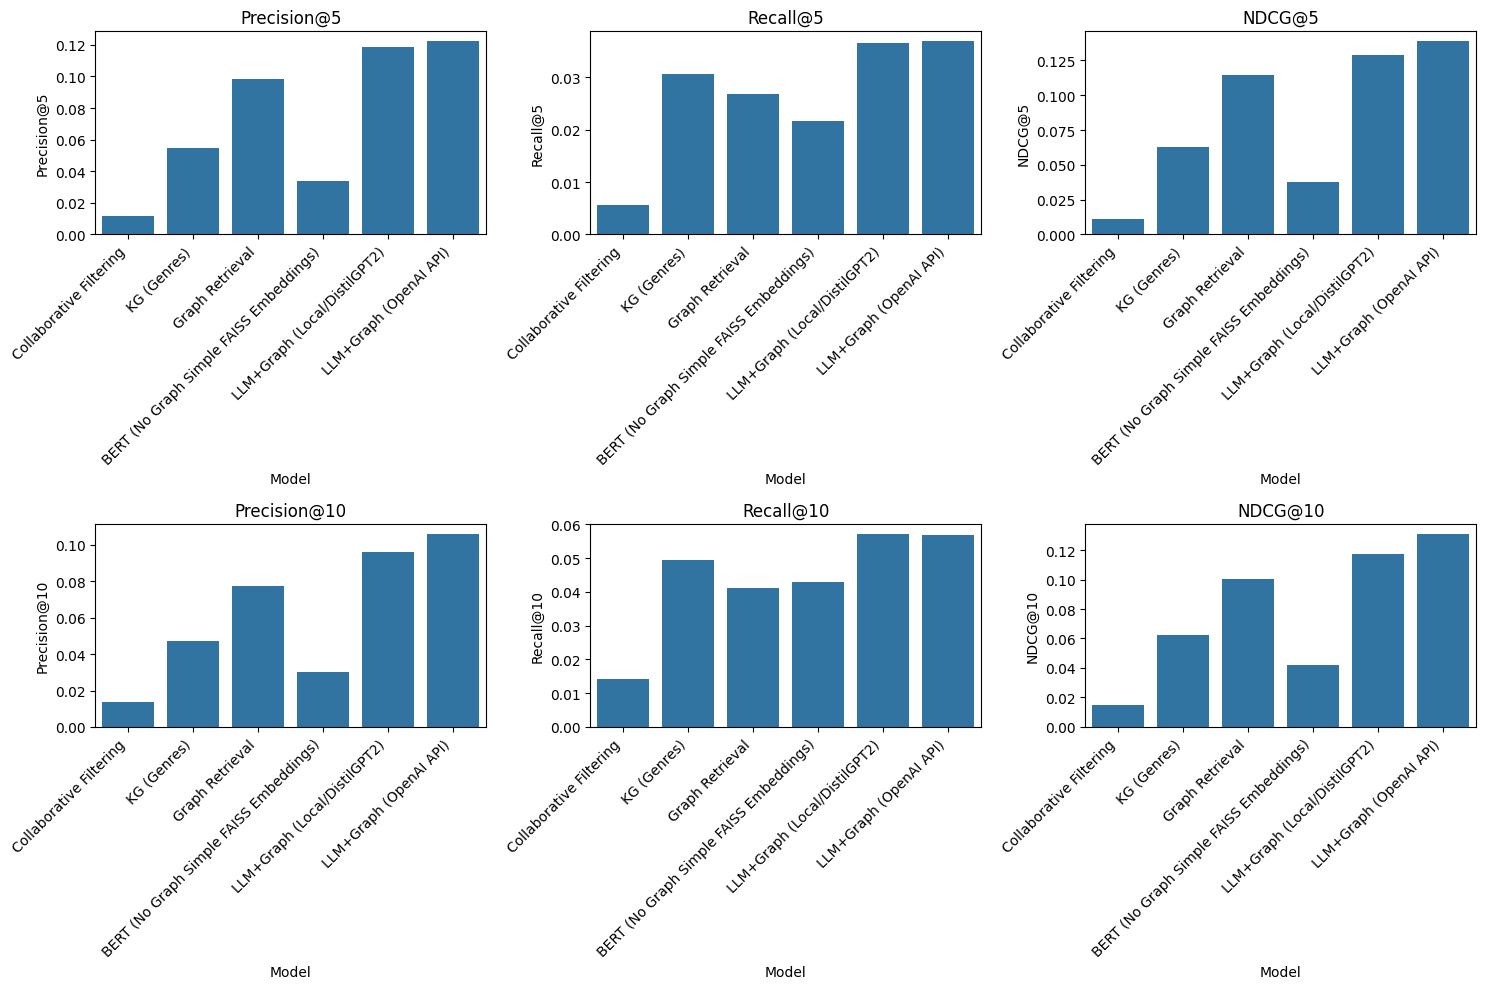

In [12]:
main()